In [41]:
!git clone https://github.com/balajisrinivas/Face-Mask-Detection

fatal: destination path 'Face-Mask-Detection' already exists and is not an empty directory.


In [42]:
!git clone https://github.com/keyurr2/face-detection

fatal: destination path 'face-detection' already exists and is not an empty directory.


In [43]:
# import the necessary packages
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Dense, Activation ,Conv2D,Flatten,MaxPool2D,Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam ,SGD
import numpy as np

In [44]:

trainPath = "/content/Face-Mask-Detection/dataset"
classesf = r"/content/face-detection/deploy.prototxt.txt"
weights = r"/content/face-detection/res10_300x300_ssd_iter_140000.caffemodel"


In [45]:
data = []
labels = []
path = []
extension = 'jpg'

In [46]:
faceNet = cv2.dnn.readNetFromCaffe(classesf, weights)

In [47]:
# faceNet model
def faceNet_model(image):
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
  faceNet.setInput(blob)
  return faceNet.forward() #get_output_layers(net)


In [48]:
# add images to list
def add_image(image,folder):
    data.append(image)
    labels.append(folder)


In [49]:
# detect faces
def detect_faces(image, folder, h, w):
  face = None
  detections  = faceNet_model(image)
  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    #conf = detections[0, 0, 0, 2]
    #if conf > 0.6:
    #print("-*-*-*-*-*-*-*-*-")
    if confidence > 0.5:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")

      try:
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (128, 128))
        # update the data and labels lists,
        add_image(face,folder)


      except:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        # update the data and labels lists,
        add_image(image,folder)
        return
  detections = None




In [50]:
#Open Folders
#now let's first check the dataset folder to have a look to its content
for folder in  os.listdir(trainPath) :
    file_list = []
    file_list.extend(gb.glob(pathname= str( trainPath +'//' + folder + '/*.' + extension)))
    print(f'For training data , found {len(file_list)} in folder {folder}')
        
    for imagePath in file_list:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        # load the image, swap color channels, and resize it to be a fixed
        # 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(imagePath)
        (Height, Width) = image.shape[:2]

        # detect faces
        detect_faces(image, folder, Height, Width)

For training data , found 1784 in folder with_mask
For training data , found 1918 in folder without_mask


In [51]:
print(len(data))

4589


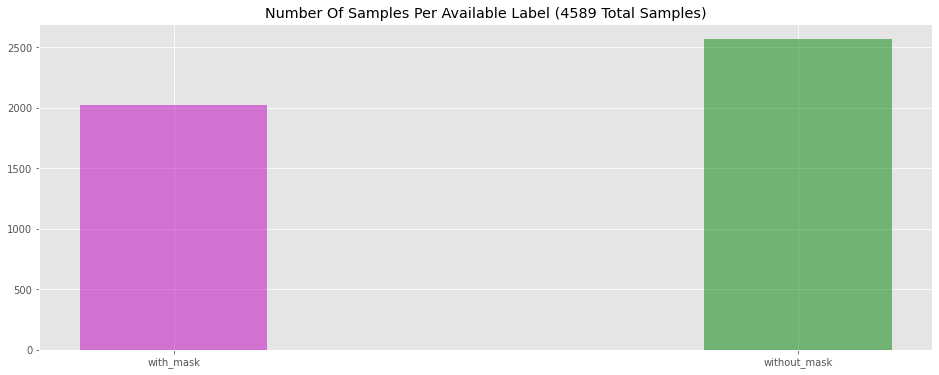

In [52]:
# Plot a bar with numbers of each class
fig = plt.figure(figsize=(16, 6))
keys = Counter(labels).keys() # equals to list(set(words))
values = Counter(labels).values() # counts the elements' frequency
plt.bar(keys,values,width=0.3,color=['m', 'g'],alpha=.5)
plt.title('Number Of Samples Per Available Label ({0:d} Total Samples)'.
          format(len(labels)))
plt.show() 

In [53]:
# The numbers of each class on two datasets.
values = list(Counter(labels).values())
print(values)


[2023, 2566]


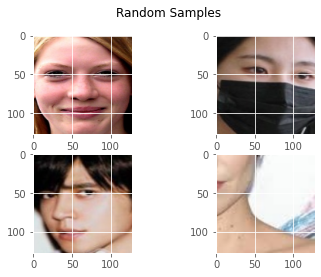

In [54]:
#random sample
# Build a 2 x 2 figure
rows, columns = 2, 2
fig, axes = plt.subplots(rows, columns)

# Variable used for indending through the image list


# Set figure title
fig.suptitle('Random Samples')

# Plot images
for i in range(rows):
    for j in range(columns):
        
        n = np.random.randint(0,len(labels))
        axes[i, j].imshow(data[n])
        
        
plt.show()

In [55]:
#normalizing data
data = np.array(data) / 255.0
labels = np.array(labels)

In [56]:
print(data.shape)
print(labels.shape)

(4589, 128, 128, 3)
(4589,)


In [57]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [58]:
print(labels.shape)

(4589, 1)


In [59]:
labels = to_categorical(labels,num_classes=2)
print(labels.shape)

(4589, 2)


In [60]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.15, stratify=labels, random_state=42)

In [61]:
# freeing memory
data = labels = path = faceNet  = None

## CNN model

In [62]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3  #learning rate
EPOCHS = 20     #number of iterations
BS = 64     #batch size

In [63]:
# Creating a Sequential model

model= Sequential()

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(128,128,3)))
model.add(Conv2D(filters=64,kernel_size = (3,3),activation='relu'))
model.add(Conv2D(filters=128,kernel_size = (3,3),activation='relu'))

model.add(MaxPool2D((2,2)))

model.add(Flatten())

#model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(48,activation='relu'))
model.add(Dropout(.5))

#output
model.add(Dense(2,activation='softmax')) 

In [64]:
# compile model
#opt = SGD(lr=INIT_LR)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) #optimizer='Adam',optimizer=opt

In [65]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 476288)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                30482496  
                                                      

In [66]:
# train the network
print("[INFO] training network...")
H = model.fit(x=trainX,y=trainY,
          validation_data=(testX,testY),
          batch_size=BS,
          epochs=EPOCHS,
          callbacks=[es],)

[INFO] training network...
Epoch 1/20
61/61 [==============================] - 22s 343ms/step - loss: 0.6569 - accuracy: 0.8305 - val_loss: 0.2434 - val_accuracy: 0.9086
Epoch 2/20
61/61 [==============================] - 21s 338ms/step - loss: 0.2055 - accuracy: 0.9318 - val_loss: 0.1900 - val_accuracy: 0.9361
Epoch 3/20
61/61 [==============================] - 21s 339ms/step - loss: 0.1419 - accuracy: 0.9508 - val_loss: 0.1476 - val_accuracy: 0.9448
Epoch 4/20
61/61 [==============================] - 21s 339ms/step - loss: 0.1067 - accuracy: 0.9674 - val_loss: 0.1357 - val_accuracy: 0.9507
Epoch 5/20
61/61 [==============================] - 21s 340ms/step - loss: 0.0923 - accuracy: 0.9669 - val_loss: 0.2180 - val_accuracy: 0.9303
Epoch 6/20
61/61 [==============================] - 21s 339ms/step - loss: 0.0681 - accuracy: 0.9772 - val_loss: 0.1681 - val_accuracy: 0.9579
Epoch 7/20
61/61 [==============================] - 21s 340ms/step - loss: 0.0469 - accuracy: 0.9844 - val_loss: 0.

In [67]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
#print(lb.classes_)
#target_names=list(map(str,lb.classes_))
#print(target_names)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.90      0.93      0.91       304
without_mask       0.94      0.92      0.93       385

    accuracy                           0.92       689
   macro avg       0.92      0.92      0.92       689
weighted avg       0.92      0.92      0.92       689



In [68]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
#total = sum(sum(cm))
#acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.2f}".format(np.trace(cm)/sum(sum(cm))))
print("sensitivity: {:.2f}".format(sensitivity))
print("specificity: {:.2f}".format(specificity))

[[282  22]
 [ 31 354]]
acc: 0.92
sensitivity: 0.93
specificity: 0.92


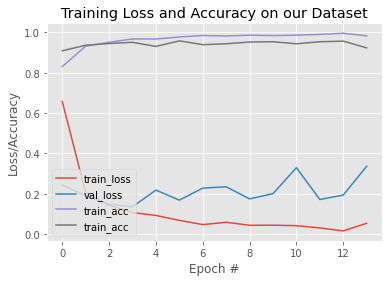

In [70]:
# plot the training loss and accuracy
#N = 20
N = es.stopped_epoch +1
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="train_acc")

plt.title("Training Loss and Accuracy on our Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [71]:
# save the model
model.save("_model.h5")

## Making predictions on new data

In [72]:
reconstructed_model = load_model("_model.h5")

In [73]:
faceNet = cv2.dnn.readNetFromCaffe(classesf, weights)

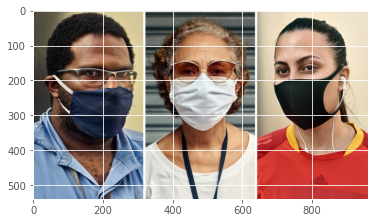

In [74]:
test = "/content/test2.jpg"
image = cv2.imread(test)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

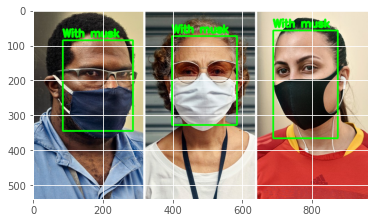

In [75]:

face = None
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
faceNet.setInput(blob)
detections  = faceNet.forward() #get_output_layers(net)
for i in range(0, detections.shape[2]):
  confidence = detections[0, 0, i, 2]
  if confidence > 0.5:
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    y = startY - 10 if startY - 10 > 10 else startY + 10
    face = image[startY:endY, startX:endX]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (128, 128))
    face = np.array(face) / 255.0
    face = np.expand_dims(face, axis=0) #convert (128, 128, 3) to (1, 128, 128, 3)
    predIdxs = model.predict(face)
    predIdxs = np.argmax(predIdxs, axis=1)
    if predIdxs[0] == 1:
      cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 4)
      cv2.putText(image, "Without musk", (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5)
    else:
      cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 4)
      cv2.putText(image, "With musk", (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 5)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

